In [141]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

In [142]:
# data loading
hate = pd.read_csv('hateXplain.csv')
final_hate = pd.read_csv('final_hateXplain.csv')


ABOUT DATASET

In [143]:
final_hate.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN


In [144]:
hate.head()

,post_id,annotator_id,label,target,post_tokens
0,1179055004553900032_twitter,1,normal,NaN,i dont think im getting my baby them white 9 h...
1,1179055004553900032_twitter,2,normal,NaN,i dont think im getting my baby them white 9 h...
2,1179055004553900032_twitter,3,normal,NaN,i dont think im getting my baby them white 9 h...
3,1179063826874032128_twitter,1,normal,NaN,we cannot continue calling ourselves feminists...
4,1179063826874032128_twitter,2,normal,NaN,we cannot continue calling ourselves feminists...


In [145]:
final_hate.shape

(20109, 7)

In [146]:
final_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       3533 non-null   object
dtypes: object(7)
memory usage: 1.1+ MB


In [147]:
final_hate['Miscellaneous'].unique()

array([nan, 'Other', 'Disability', 'Refugee', 'Minority', 'Economic'],
      dtype=object)

In [148]:
for column in final_hate.columns[1:]:
    print('*' * 10, f"Unique Values in {column} column", "*" * 10)
    print(final_hate[column].unique())

********** Unique Values in label column **********
['normal' 'offensive' 'hatespeech']
********** Unique Values in Race column **********
['No_race' 'African' 'Asian' 'Caucasian' 'Hispanic' 'Arab' 'Indian'
 'Indigenous']
********** Unique Values in Religion column **********
['Nonreligious' 'Jewish' 'Islam' 'Christian' 'Hindu' 'Buddhism']
********** Unique Values in Gender column **********
['No_gender' 'Women' 'Men']
********** Unique Values in Sexual Orientation column **********
['No_orientation' 'Homosexual' 'Heterosexual' 'Asexual' 'Bisexual']
********** Unique Values in Miscellaneous column **********
[nan 'Other' 'Disability' 'Refugee' 'Minority' 'Economic']


In [149]:
# Fill NaN values in the Miscellaneous column with 'Unknown'
final_hate['Miscellaneous'].fillna('Unknown', inplace=True)

C:\Users\nopi\AppData\Local\Temp\ipykernel_15228\1425355971.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_hate['Miscellaneous'].fillna('Unknown', inplace=True)


In [150]:
final_hate['Miscellaneous'].unique()

array(['Unknown', 'Other', 'Disability', 'Refugee', 'Minority',
       'Economic'], dtype=object)

EDA (Exploratory Data Analysis)

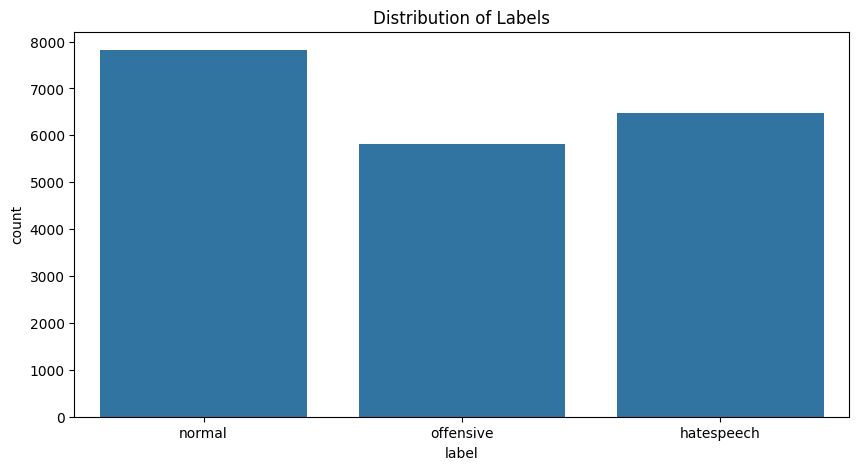

In [151]:
plt.figure(figsize=(10, 5))


sns.countplot(x = 'label', data=final_hate, )
plt.title('Distribution of Labels');

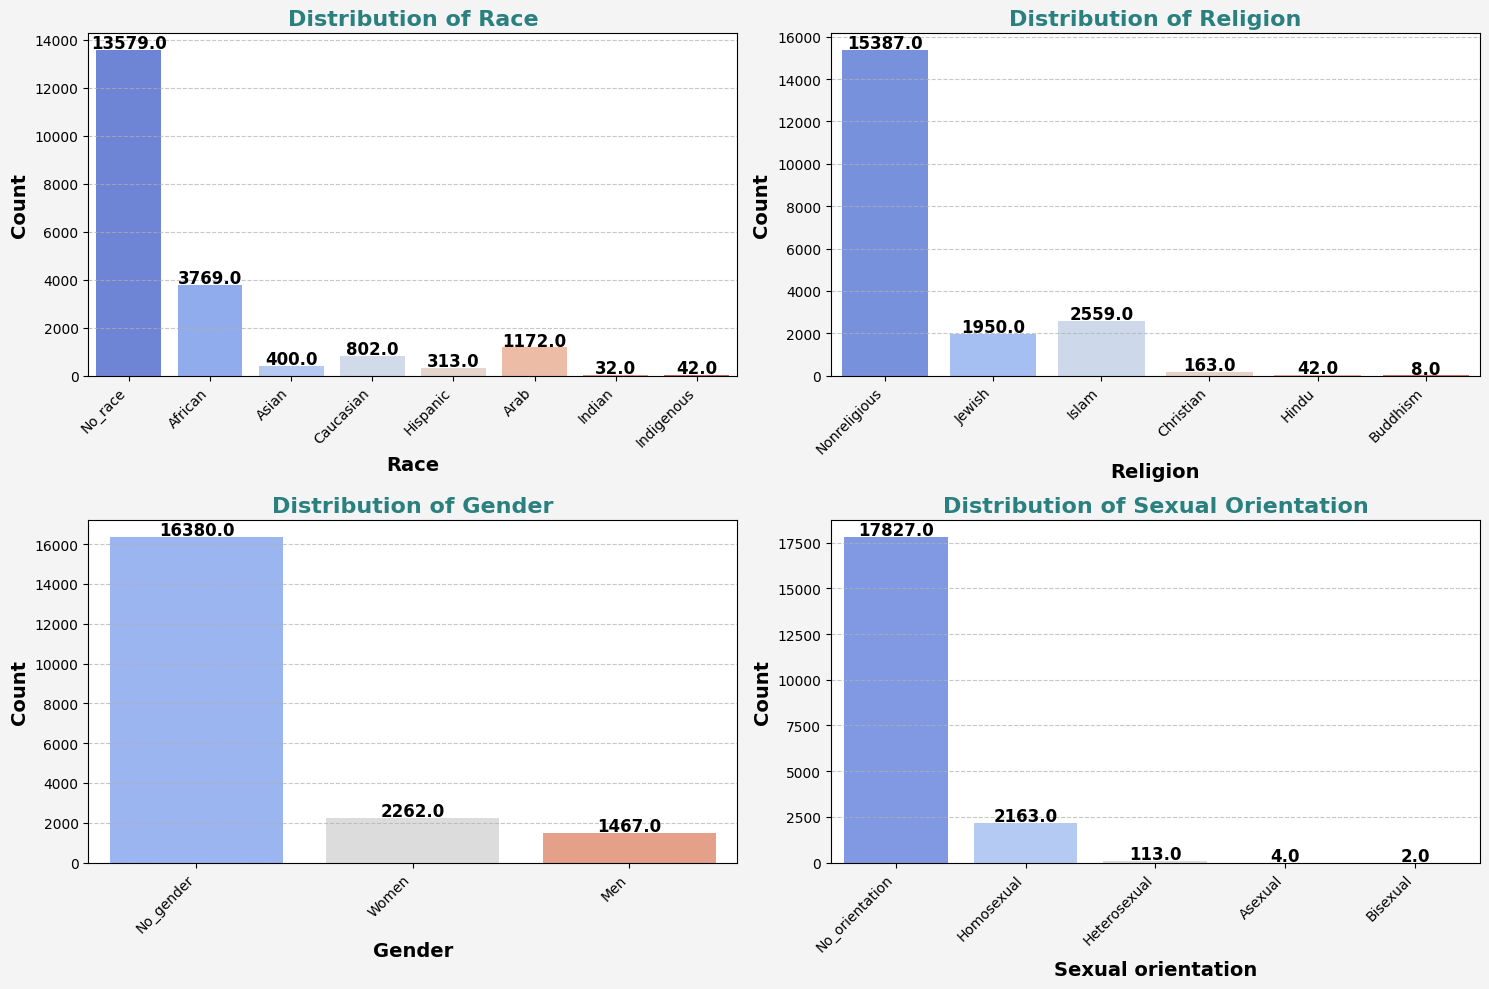

In [152]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.patch.set_facecolor('#f4f4f4')  # Background color of the figure

# Loop through columns and axes to create count plots
for i, col in enumerate(final_hate.columns[2:6]):
    ax = sns.countplot(x=col, data=final_hate, ax=axes[i // 2, i % 2], hue=col, palette='coolwarm', legend=False)
    
    # Title and labels
    ax.set_title(f'Distribution of {col}', fontsize=16, weight='bold', color='#2A7F7F')
    ax.set_xlabel(col.capitalize(), fontsize=14, weight='bold')
    ax.set_ylabel('Count', fontsize=14, weight='bold')

    # Annotate counts on the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5),  # Vertical offset
                    textcoords='offset points',
                    fontsize=12, color='black', weight='bold')

    # Set grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set xticks and then rotate labels
    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

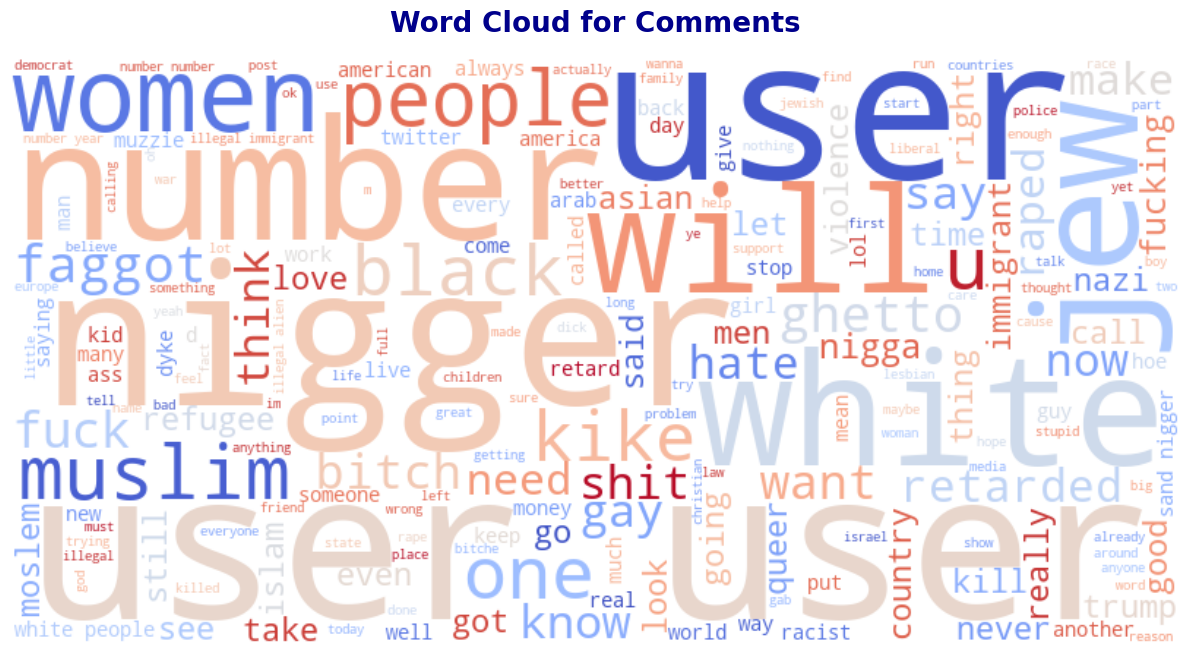

In [153]:
# Combine all comments into one text string
text = ' '.join(comment for comment in final_hate['comment'].dropna())

# Create a word cloud object with enhanced appearance
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='coolwarm',  # Change colormap for better visuals
    max_words=200,        # Limit the number of words
    contour_color='black', # Add contour to words
    contour_width=3,      # Increase contour width
    random_state=42       # Set a seed for reproducibility
).generate(text)

# Display the word cloud using matplotlib with enhancements
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title(
    'Word Cloud for Comments', 
    fontsize=20, 
    weight='bold', 
    color='darkblue', 
    pad=20  # Add padding around the title
)

# Add a slight shadow to the word cloud for depth
plt.gca().patch.set_facecolor('lightgrey')  # Set background color

# Show the plot
plt.tight_layout()
plt.show()

In [154]:
# Verinin temizlenmesi
final_hate.rename(mapper={'comment': 'post_tokens'}, inplace=True, axis=1)


In [155]:
final_hate


,post_tokens,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,Unknown
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,Unknown
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,Unknown
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,Unknown
...,...,...,...,...,...,...,...
20104,😂 😂 😂 😂 😂 y ’ all be so mad at caucasians fail...,offensive,African,Nonreligious,No_gender,No_orientation,Unknown
20105,🤔 🤔 🤔 🤔 mmm yes the trebuchet memes are much n...,hatespeech,Arab,Islam,No_gender,No_orientation,Unknown
20106,🤣 this so ghetto i ’ m ready to get tf,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
20107,🤣 🤣 😂 😂 🤣 🤣 😂 😂 🤣 🤣 you spelled my name wrong ...,hatespeech,Arab,Nonreligious,No_gender,No_orientation,Unknown


In [156]:
hate = hate.dropna(subset=['post_id', 'label', 'post_tokens'])
hate

,post_id,annotator_id,label,target,post_tokens
0,1179055004553900032_twitter,1,normal,NaN,i dont think im getting my baby them white 9 h...
1,1179055004553900032_twitter,2,normal,NaN,i dont think im getting my baby them white 9 h...
2,1179055004553900032_twitter,3,normal,NaN,i dont think im getting my baby them white 9 h...
3,1179063826874032128_twitter,1,normal,NaN,we cannot continue calling ourselves feminists...
4,1179063826874032128_twitter,2,normal,NaN,we cannot continue calling ourselves feminists...
...,...,...,...,...,...
60439,9992513_gab,253,hatespeech,Asian,it is awful look at world demographics asians ...
60440,9992513_gab,222,offensive,Asian,it is awful look at world demographics asians ...
60441,9998729_gab,200,hatespeech,"African, Islam",the jewish globalist elite have only imported ...
60442,9998729_gab,202,offensive,"Islam, Jewish",the jewish globalist elite have only imported ...


In [157]:
# Özellik ve etiketlerin hazırlanması
grouped_df = hate.groupby('post_id')
unique_label = grouped_df['label'].agg(lambda x: x.value_counts().index[0]).to_frame().reset_index()

In [158]:
X_train = pd.merge(left=hate[['post_id', 'post_tokens']], right=unique_label, on='post_id', how='inner').drop_duplicates(subset=['post_id']).reset_index(drop=True)
X_train

,post_id,post_tokens,label
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,normal
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists...,normal
2,1178793830532956161_twitter,nawt yall niggers ignoring me,normal
3,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,hatespeech
4,1179085312976445440_twitter,this bitch in whataburger eating a burger with...,hatespeech
...,...,...,...
20143,9989999_gab,if ur still on twitter tell carlton i said his...,offensive
20144,9990225_gab,when i first got on here and said i hate trump...,offensive
20145,9991681_gab,was macht der moslem wenn der zion gegen seine...,normal
20146,9992513_gab,it is awful look at world demographics asians ...,hatespeech


In [159]:
# Özelliklerin oluşturulması
def get_features(cv, tfidf, x):
    cv_feature = cv.transform(x['post_tokens'])
    tfidf_feature = tfidf.transform(x['post_tokens'])
    return (cv_feature + tfidf_feature) / 2

def get_labels(oe, x):
    y = oe.transform(x[['label']])
    return y

cv = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))
tfidf = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))
oe = OrdinalEncoder(categories=[['normal', 'offensive', 'hatespeech']])

cv.fit(X_train['post_tokens'])
tfidf.fit(X_train['post_tokens'])
oe.fit(X_train[['label']])

x_train = get_features(cv, tfidf, X_train)
y_train = get_labels(oe, X_train)
x_test = get_features(cv, tfidf, final_hate)
y_test = get_labels(oe, final_hate)

c:\Users\nopi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [160]:
# MLPClassifier modelinin eğitilmesi
mlp = MLPClassifier(random_state=0, verbose=True, batch_size=1000, max_iter=10, warm_start=True)
mlp.fit(x_train, y_train.ravel())

Iteration 1, loss = 1.01568027
Iteration 2, loss = 0.60928336
Iteration 3, loss = 0.33534730
Iteration 4, loss = 0.19372523
Iteration 5, loss = 0.12270869
Iteration 6, loss = 0.08371074
Iteration 7, loss = 0.06095834
Iteration 8, loss = 0.04659012
Iteration 9, loss = 0.03695221
Iteration 10, loss = 0.03016001


c:\Users\nopi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=1000, max_iter=10, random_state=0, verbose=True,
              warm_start=True)

In [166]:
# Tahminler ve performans raporu
y_pred = mlp.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      7818
         1.0       0.91      0.90      0.90      5807
         2.0       0.94      0.91      0.93      6484

    accuracy                           0.93     20109
   macro avg       0.93      0.93      0.93     20109
weighted avg       0.93      0.93      0.93     20109



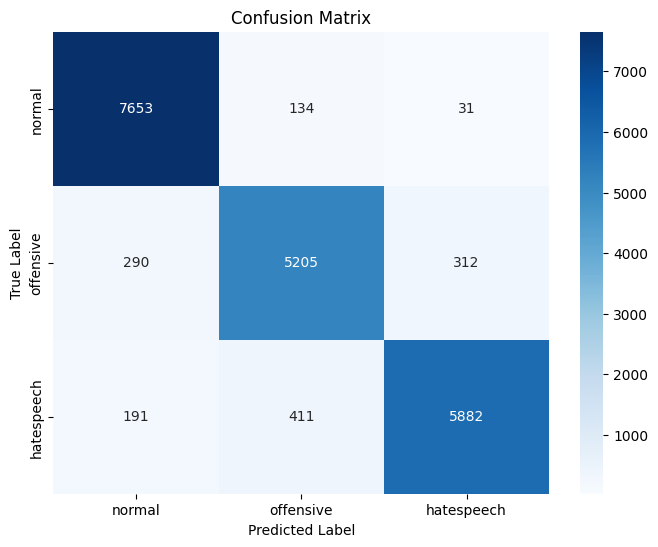

In [162]:
# Confusion matrix görselleştirmesi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'offensive', 'hatespeech'], yticklabels=['normal', 'offensive', 'hatespeech'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [163]:
# Modelin başarısını görselleştirme
accuracy = mlp.score(x_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.93


In [164]:
# 'play' fonksiyonuyla örnek tahminler
def play(input_text):
    df = pd.DataFrame({'post_tokens': [input_text]})
    combine_feature = get_features(cv, tfidf, df)
    y_pred = mlp.predict(combine_feature)
    classes = ['normal', 'offensive', 'hatespeech']
    return classes[int(y_pred[0])]

In [165]:
def print_prediction(input_text):
    result = play(input_text)
    print(f"\n{'='*30}\nInput Text: {input_text}\nPredicted Label: {result}\n{'='*30}")

# Örnek tahminler
print_prediction('you are beautiful')
print_prediction('you are stupid')
print_prediction('i dont like you')
print_prediction('are you Muslim?')
print_prediction('fuck you')



Input Text: you are beautiful
Predicted Label: normal

Input Text: you are stupid
Predicted Label: hatespeech

Input Text: i dont like you
Predicted Label: normal

Input Text: are you Muslim?
Predicted Label: offensive

Input Text: fuck you
Predicted Label: hatespeech
